## Library import

In [1]:
import time

import numpy as np
from scipy.stats import invwishart
import matplotlib.pyplot as plt

from multivariate_t import multivariate_t
from huber_mean_estimation import huber, home

# 1D experiments

In [2]:
N=100

def sample_corrupted_pareto(i):
    rng=np.random.RandomState(i)
    N_c = rng.binomial(N,0.05)
    x= np.hstack([rng.pareto(5,size=N-N_c)+1 , 3*np.ones(N_c)]) 
    return x
mean = 5/(5-1)

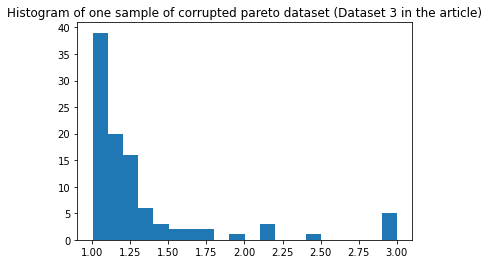

In [3]:
plt.hist(sample_corrupted_pareto(0),bins=20)
plt.title('Histogram of one sample of corrupted pareto dataset (Dataset 3 in the article)')
plt.show()

### The following cell is computationally expensive, run if you have the time.
As an indication, it takes  1min10s on a 16-cores i9 cpu.

In [4]:

M=50
n_jobs = -1 # Use all the cpu
benchmark = huber(beta=0.46)
lepski1 = huber(beta=None,grid=30, t=0.1, n_jobs = n_jobs)
lepski2 = huber(beta=None,grid=30, t=1, n_jobs = n_jobs)
lepski3 = huber(beta=None,grid=30, t=5, n_jobs = n_jobs)

res=[]
init_time=time.time()
for f in range(M):
    X = sample_corrupted_pareto(f)
    
    huber_chap1=lepski1.estimate(X)
    
    huber_chap2=lepski2.estimate(X)
    
    huber_chap3=lepski3.estimate(X) 
    
    res+=[np.abs(np.array([np.median(X),benchmark.estimate(X), huber_chap1,huber_chap2, huber_chap3])-mean)]
print('Computation finished in ', np.round(time.time()-init_time,2),'s')

Computation finished in  70.51 s


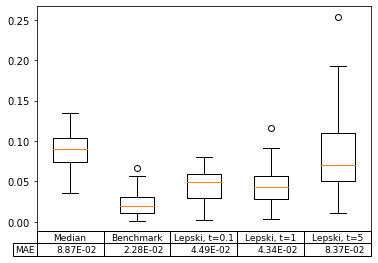

In [5]:
plt.boxplot(np.array(res))

the_table = plt.table(cellText=[['%.2E' % s for s  in np.mean(np.array(res), axis=0)]],
                      rowLabels=['MAE'],
                      colLabels=["Median","Benchmark", "Lepski, t=0.1","Lepski, t=1", "Lepski, t=5"],
                      loc='bottom')
plt.xticks([0], [''])
plt.subplots_adjust(bottom=0.1)
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)

# MultiD experiments

### Plot as dimension increases: illustration of minimax rates

In [10]:
N=50
result=[]
Dims = np.arange(50,10560, 500)
for d in Dims:
    X = np.random.normal(size=[N,d])
    print("\r Estimation for d = %.0F" %d, end=" ")
    for f in range(5):
        X[-f]=np.random.normal(size=d)+10
    Ds = np.logspace(-3,3, num=100)
    res = []
    for delta in Ds:
        est = huber(delta, maxiter=100)
        res += [np.linalg.norm(est.estimate(X))]
    result += [np.min(res)]

 Estimation for d = 10550 

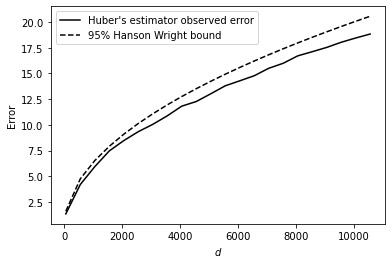

In [3]:
t= np.log(1/0.05)
plt.plot(Dims,result, label="Huber's estimator observed error",c='k')
plt.plot(Dims,np.sqrt(2*Dims/N+9*t/N), label='95% Hanson Wright bound', c='k', linestyle = '--')
plt.xlabel('$d$')
plt.ylabel('Error')
plt.legend()
plt.savefig('hanson_wright.pdf')

In [4]:
import time
N=50
result=[]
Dims = np.arange(50,10560, 500)
for d in Dims:
    a = time.time()
    X = np.random.normal(size=[N,d])
    print("\r Estimation for d = %.0F" %d, end=" ")
    for f in range(5):
        X[-f]=np.random.normal(size=d)+10
    Ds = np.logspace(-3,3, num=100)
    res = []
    for delta in Ds:
        est = huber(delta, maxiter=100)
        res += [np.linalg.norm(est.estimate(X))]
    result += [(time.time()-a)/100]

 Estimation for d = 10550 

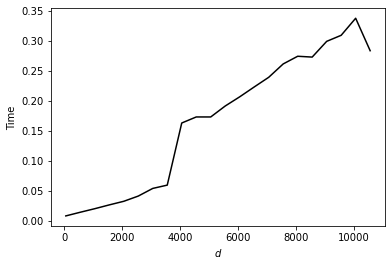

In [12]:
plt.plot(Dims,result,c='k')
plt.xlabel('$d$')
plt.ylabel('Time')
# plt.title("Mean computation time of one estimation in s")
plt.savefig('complexity.pdf')

### Comparison to other estimators on a skewed, corrupted, high dimensional and heavy-tailed dataset.

In [110]:
N=100
d=200
s=invwishart.rvs(2*d,np.eye(d), random_state=0)
eps = 0.4
mean = 0.3*eps*np.ones(d)

In [111]:
print(np.trace(s),np.max(np.linalg.eigvals(s)))

0.9997899071037382 0.02719934872983282


In [112]:

def sample():
    law = multivariate_t(shape=s, df = 3)
    X = law.rvs(size=N)
    law2 = multivariate_t(mean = 0.3*np.ones(d),shape=s, df = 3)
    Y = law2.rvs(size=N)
    melange_eps = np.random.binomial(1,eps,size=N)==1   

    # Mixture model
    M = np.zeros(X.shape)
    M[~melange_eps]=X[~melange_eps]
    M[melange_eps]=Y[melange_eps]
    # add outliers
    for f in range(1,6):
        M[-f]=np.random.normal(size=d)+10
    return M

M = sample()

In [113]:
print(np.linalg.norm(np.mean(M,axis=0)-mean))
print(np.linalg.norm(np.median(M,axis=0)-mean))

6.667349027820068
0.9997996302060022


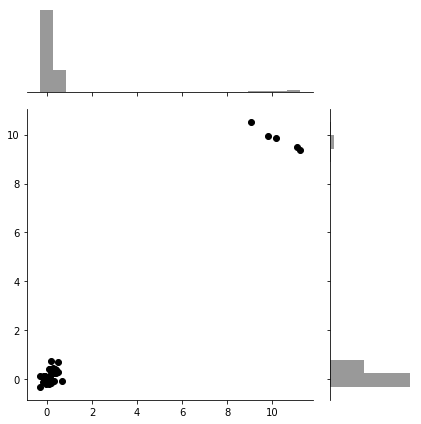

In [114]:
import seaborn as sns
g = sns.jointplot(M[:,0],M[:,1],ratio = 3,marginal_kws=dict(bins=20), color='k')

plt.savefig('dataset6.pdf')

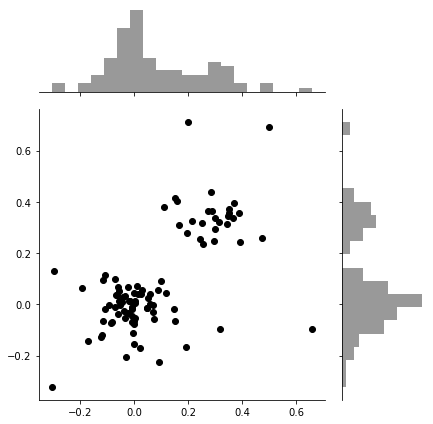

In [115]:
g = sns.jointplot(M[:-6,0],M[:-6,1],ratio = 3,marginal_kws=dict(bins=20), color='k')
plt.savefig('dataset6_zoomed.pdf')

### Brut-Force choice of parameter

In [116]:
res=[]
Ds = np.logspace(-3,3, num=200)
import time
for delta in Ds:
    est = huber(delta, maxiter=200)
    res += [np.linalg.norm(est.estimate(M)-mean)]


Minimum error obtained  0.1772845368747644


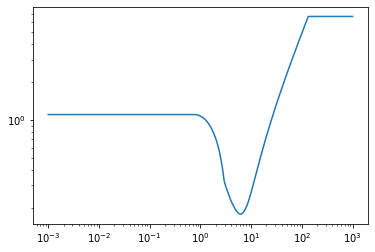

In [117]:
plt.loglog(Ds,res)
print("Minimum error obtained " , np.min(res))

### Comparison of different estimators

In [119]:
B=30

result = np.zeros([4,B])

for f in range(B):
    print("\r Estimation on run %.0F" %f, end=" ")

    M = sample()
    result[0,f] = np.linalg.norm(np.mean(M,axis=0)-mean)
    result[1,f] = np.linalg.norm(np.median(M,axis=0)-mean)
    
    Ds = np.logspace(-3,3, num=100)
    res = []
    for delta in Ds:
        est = huber(delta, maxiter=100)
        res += [np.linalg.norm(est.estimate(M)-mean)]
    result[2,f] = np.min(res)

    Ks = np.arange(1,N//2,2)
    res = []
    for delta in Ds:
        for K in Ks:
            est = home(K,delta, maxiter=100)
            res += [np.linalg.norm(est.estimate(M)-mean)]
    result[3,f] = np.min(res)

 Estimation on run 29 

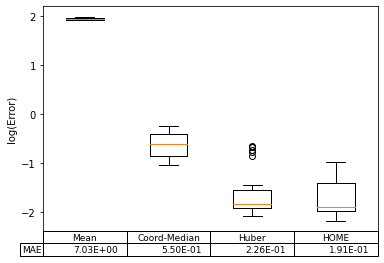

In [120]:
plt.boxplot(np.log(result.T), labels=['Mean','Coord-Median','Huber','HOME'])
plt.ylabel('log(Error)')
the_table = plt.table(cellText=[['%.2E' % s for s  in np.mean(np.array(result.T), axis=0)]],
                      rowLabels=['MAE'],
                      colLabels=['Mean','Coord-Median','Huber','HOME'],
                      loc='bottom')
plt.xticks([0], [''])
plt.subplots_adjust(bottom=0.1)
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
plt.savefig('comparison_high_dim.pdf')